# Split Reads into subreads based on primer

### Context:
52 SNP locations were PCR amplified and the amplicons ligated before nanopore sequencing.  The reads are split into potential amplicons by looking up the primer pairs using fuzzy regex and amplicon size constraints.

In [ ]:
# Checking current fast5 format

import h5py

# Example f5 file
f5 = h5py.File('/media/sf_vm_shared/nanopore/snp_data/pass2_total/FW01C250_20160531_FN_MN15671_sequencing_run_SNPforID_310516_26276_ch1_read58_strand.fast5')

# Walk the file structure
def printname(name):
  print(name,'(group)' if type(f5[name]) == h5py._hl.group.Group else '')

f5.visit(printname)

## Extract fastq sequences from fast5 containers generated by the Nanopore basecalling application

In [2]:
import h5py, glob

infiles          = glob.glob('/media/sf_vm_shared/nanopore/snp_data/pass2_total/*fast5')
outfile          = '/media/sf_vm_shared/nanopore/results/ligated_snp_amplicon_reads.fastq'
outfile          = open(outfile, 'wt')
withoutFQcounter = 0
fast5FileCount   = 0

for f5file in infiles:
  f5 = h5py.File(f5file)
  fast5FileCount += 1
  try:
    fq = f5['Analyses/Basecall_2D_000/BaseCalled_2D/Fastq']
    outfile.write(fq.value.decode())
  except KeyError:
    withoutFQcounter += 1 
  f5.close()
outfile.close()

print('{}/{} fast5 files without called fastq sequence'.format(withoutFQcounter, fast5FileCount))


0/14324 fast5 files without called fastq sequence


## Plot read length distribution

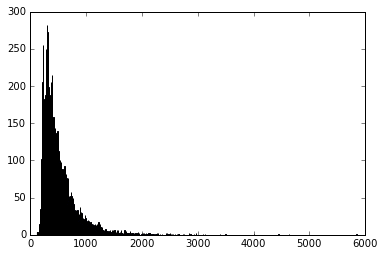

In [3]:
%matplotlib inline

from itertools import count
import matplotlib.pyplot as plt

with open('/media/sf_vm_shared/nanopore/results/ligated_snp_amplicon_reads.fastq') as fastq:
  c     = count(0)
  reads = [line for line in fastq if next(c)%4 == 1]

# Plot length histogram
plt.hist([len(r) for r in reads], bins=1000)
plt.show()

## Load primer sequence

In [4]:
# File format is comma separated: snp_name,forward_primer_seq,reverse_primer_seq

primerFile = '/media/sf_vm_shared/nanopore/snp_data/primers2.csv'
primerData = {}

with open(primerFile) as f:
  for l in f:
    l = l.strip()
    
    # Ignore the column header line (should start with a '#')
    if l.startswith('#'):
      continue
    
    locus, fPrimer, rPrimer = l.split(',')
    primerData[locus] = {'f': fPrimer, 'r': rPrimer}
    
print('Loaded primers for {} loci'.format(len(primerData)))


Loaded primers for 52 loci


 ## Load sequencing data

In [5]:
readFile = '/media/sf_vm_shared/nanopore/results/ligated_snp_amplicon_reads.fastq'
readData = {}

with open(readFile) as f:
  cnt = 0

  for l in f:
    cnt += 1
    if cnt % 4 == 1:
      seqName = l.strip()
    elif cnt % 4 == 2:
      seqData = l.strip()
      readData[seqName] = seqData
    else:
      continue
            
print('Loaded {} sequences'.format(len(readData)))


Loaded 14324 sequences


## Splitting reads into subreads based on the primersequences

In [6]:
# Utility functions
#

def reverseComplement(seq):
  transTab = str.maketrans('agctyrwskmdvhbAGCTYRWSKMDVHB', 'tcgarywsmkhbdvTCGARYWSMKHBDV')
  return seq.translate(transTab)[::-1]


In [7]:
# Map primer sequences and save spliced amplicons.  Using a fuzzy regex is relatively slow but permits
# finetuning the number of errors we allow to occur in the primers.
#

import regex

maxMisMatch  = 3
matchPosData = {}
ampliconSeq  = []
ampLenData   = {}

for locus in sorted(primerData):
    # Init
    ampLenData[locus] = {}
        
    # Regex
    pFor   = regex.compile('(?e)({}){{e<={}}}'.format(primerData[locus]['f'], maxMisMatch))
    pForRc = regex.compile('(?e)({}){{e<={}}}'.format(reverseComplement(primerData[locus]['f']), maxMisMatch))
    pRev   = regex.compile('(?e)({}){{e<={}}}'.format(primerData[locus]['r'], maxMisMatch))
    pRevRc = regex.compile('(?e)({}){{e<={}}}'.format(reverseComplement(primerData[locus]['r']), maxMisMatch))
    
    allowedPairs      = [(pFor, pRevRc), (pRev, pForRc)]
    allowedPairSense  = ('sense', 'anti-sense')
    allowedPairSeqLen = ((len(primerData[locus]['f']), len(primerData[locus]['r'])), (len(primerData[locus]['r']), len(primerData[locus]['f'])))
    minAmpliconSize   = 50
    maxAmpliconSize   = 150
    readCnt           = 0
    
    # Print locus name to indicate progress
    print(locus)
    
    for seq in readData:
        readCnt += 1
        
        for i in range(len(allowedPairs)):
            pair    = allowedPairs[i]
            sense   = allowedPairSense[i]
            posList = [[],[]]
            
            for match in pair[0].finditer(readData[seq]):
                b,e = match.span()
                posList[0].append(b) # Including the primer
                
            for match in pair[1].finditer(readData[seq]):
                b,e = match.span()
                posList[1].append(e) # Including the primer
                
            # Retain possible pairs based on amplicon size
            if len(posList[0]) and len(posList[1]):                
                for p1 in posList[0]:
                    for p2 in posList[1]:
                        if minAmpliconSize < (p2 - p1) < maxAmpliconSize:
                            # We have a potential amplicon?
                            sense   = '{} - {} ({})'.format(p1, p2, sense)
                            ampSeq  = readData[seq][p1:p2]
                            ampLen  = len(ampSeq)
                            ampName = '{} {} ({}): {} {}'.format(len(ampliconSeq) + 1, locus, ampLen, sense, seq)
                            ampliconSeq.append((ampName, ampSeq))
                            
                            # Keep amplicon lengths
                            if ampLen in ampLenData[locus]:
                                ampLenData[locus][ampLen] += 1
                            else:
                                ampLenData[locus][ampLen] = 1
                                                    
    
# Save potential amplicons
outFile = '/media/sf_vm_shared/nanopore/results/potential_snp_amplicons_{}mism.fasta'.format(maxMisMatch)

with open(outFile, 'w') as f:
    for amplicon in ampliconSeq:
        f.write('>' + amplicon[0] + '\n')
        f.write(amplicon[1] + '\n')
    
print('Done')

rs1005533
rs1015250
rs1024116
rs1028528
rs1029047
rs1031825
rs10495407
rs1335873
rs1355366
rs1357617
rs1360288
rs1382387
rs1413212
rs1454361
rs1463729
rs1490413
rs1493232
rs1528460
rs1886510
rs1979255
rs2016276
rs2040411
rs2046361
rs2056277
rs2076848
rs2107612
rs2111980
rs251934
rs2830795
rs2831700
rs354439
rs717302
rs719366
rs722098
rs727811
rs729172
rs733164
rs735155
rs737681
rs740910
rs763869
rs8037429
rs826472
rs873196
rs876724
rs891700
rs901398
rs907100
rs914165
rs917118
rs938283
rs964681
Done


## Count the number of retrieved amplicons

In [9]:
!grep -c ">" /media/sf_vm_shared/nanopore/results/potential_snp_amplicons_3mism.fasta

23057
